In [1]:
#configure plotting
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

In [4]:
np.random.seed(0)

---

# Simple Matrix Factorization

In [5]:
from movieLensAnalyzer import MovieLensAnalyzer 
movieLensAnalyzer = MovieLensAnalyzer()
R_ = movieLensAnalyzer.trainRatingMatrix # take some matrix... just check if it trains and if so how quickly

In [6]:
import edward as ed

N, M = R_.shape
D = 30
BATCH = 200 # Higher batch = more stable gradients but (maybe) slower training.

# We use r_ph to feed in only the elements in R_ that idx_i and idx_j correspond to.
r_ph  = tf.placeholder(tf.float32, name="batch_r")
idx_i = tf.placeholder(tf.int32, name="idx_i")
idx_j = tf.placeholder(tf.int32, name="idx_j")

# "Priors" p(Z)
U = ed.models.Normal(loc=tf.zeros([N, D]), scale=tf.ones([N, D]))
V = ed.models.Normal(loc=tf.zeros([M, D]), scale=tf.ones([M, D]))

# P(X|Z)
U_selected = tf.gather(U, idx_i)
V_selected = tf.gather(V, idx_j)
R = ed.models.Normal(loc=tf.reduce_sum(tf.multiply(U_selected, V_selected), axis=1), scale=tf.ones(BATCH))

# VI
qU = ed.models.Normal(loc=tf.Variable(tf.zeros([N, D])), scale=tf.Variable(tf.ones([N, D])))
qV = ed.models.Normal(loc=tf.Variable(tf.zeros([M, D])), scale=tf.Variable(tf.ones([M, D])))

# Testing
U_samples = qU.sample(100)
V_samples = qV.sample(100)

In [7]:
def mse():
    '''Calculate MSE using mean of a sample of r_hats, on only the ratings that are not 0'''
    U_samples_, V_samples_ = ed.get_session().run([U_samples, V_samples])
    R_samples_ = []
    for i in range(U_samples_.shape[0]):
        R_samples_.append(np.matmul(U_samples_[i], np.transpose(V_samples_[i])))
    R_samples_ = np.array(R_samples_)
    return np.mean(np.square(np.mean(R_samples_, axis=0) - R_)[np.where(R_)])

In [8]:
inference = ed.KLqp({U: qU, V: qV}, data={R: r_ph}) 
# TODO Try also passing in `n_samples` into inference.initialize. 
# This is how many samples of the latents to draw in estimating gradient.
# By default it's 1. More should be better!
inference.initialize(scale={R: N*M/BATCH}, n_iter=5000)
ed.get_session().run(tf.global_variables_initializer())

In [9]:
# get an idea how big this problem is.
print("Notice the size of the variables we're training:")
display(tf.trainable_variables())
print("There are {} ratings in this matrix of size {}".format(np.array(np.where(R_)).shape[1], R_.shape))
print("Training will go over {} random ratings.".format(inference.n_iter * BATCH))

Notice the size of the variables we're training:


[<tf.Variable 'Variable:0' shape=(943, 30) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(943, 30) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(1682, 30) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1682, 30) dtype=float32_ref>]

There are 50000 ratings in this matrix of size (943, 1682)
Training will go over 1000000 random ratings.


In [10]:
print("Prior MSE:", mse())

Prior MSE: 14.2187184696


5000/5000 [100%] ██████████████████████████████ Elapsed: 38s | Loss: 2738463.000


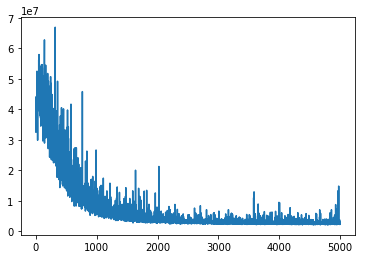

In [11]:
seen_indices = np.array(np.where(R_))
info_dicts = []
for _ in range(inference.n_iter):
    # Train on a batch of BATCH_SIZE random elements each iteration.
    rand_idx = np.random.choice(seen_indices.shape[1], BATCH, replace=False)
    idx_i_ = seen_indices[0, rand_idx]
    idx_j_ = seen_indices[1, rand_idx]
    feed_dict = {
        idx_i: idx_i_,
        idx_j: idx_j_,
        r_ph: R_[idx_i_, idx_j_]
    }
    info_dict = inference.update(feed_dict=feed_dict)
    info_dicts.append(info_dict)
    inference.print_progress(info_dict)
    
_ = plt.plot([x['loss'] for x in info_dicts])

In [12]:
print("Posterior MSE:", mse())

Posterior MSE: 0.691568105854
